# This notebooks only contains the experimental codes for var-speed condition

In [1]:
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import scipy.stats
import math
import datetime
from copy import deepcopy
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings
warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import mlab
from mpl_toolkits.mplot3d import Axes3D


root='/data'
%run Animal_Tags.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
%run UtilityTools.ipynb

defaultParam={
    "binSize":0.25,
    "trialOffset":20., #max end of trial, in seconds (position will be cutted)
    "sigmaSmoothPosition":0.1,  #smooth the position
    #"sigmaSmoothPosition":0.33 for pavel dataType
    "sigmaSmoothSpeed":0.3, #smooth the speed
    "positionDiffRange": [2.,5.], #min and max differences allowed between two consecutive positions
                                  #min to correct start, max to correct jumps
    "pawFrequencyRange":[2.,10.],
    "startAnalysisParams":[10,0.2,0.5],
    "cameraToTreadmillDelay":2., #seconds, usual time between camera start and treadmill start
    "nbJumpMax" : 100., #if jumps>nbJumpMax, trial is badly tracked
    
    #parameter to detect end of trial (first position minima)
    "endTrial_backPos":55,  # minima is after the animal went once to the back (after first time position>backPos)
    "endTrial_frontPos":30, # minima's position is in front of treadmill (position[end]<frontPos)
    "endTrial_minTimeSec":4, # minima is after minTimeSec seconds (time[end]>minTimeSec)
    }

### trimmed mean function
averaging after removing outliers (-+3 SDs)

In [2]:
def trimmed_mean(x):
    if len(x)<50:
        return np.nanmean(x)
    SD=np.nanstd(x)
    MEAN=np.nanmean(x)
    out=scipy.stats.tmean(x, limits=(MEAN-3*SD,MEAN+3*SD), inclusive=(False, False), axis=None)
    return out

### Get the mean speed for variable speed sessions

In [ ]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     'initialSpeed':['10','var'],
     'Speed':['var'],
     #'Tag':'Control'
              }
SESSION_LIMIT=100


In [ ]:
animalList=batch_get_animal_list(root,AnimalProfile)
try:
    animalList.remove('Rat106')
except:pass
data=[]
sessionN=0
for animal in  animalList:
    sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
    if SESSION_LIMIT >0:
        tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
    else:
        tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
    for session in tmp:
        filePath=os.path.join(root,animal,'Experiments',session,session)
        varSpd=read_in_file(filePath,paramName=' ',extension='.variablespeed',valueType=float)
        if isinstance(varSpd,np.ndarray):
            if max(varSpd)>40:print(session)
            data.extend(varSpd.tolist())
            sessionN+=1

print('good sessions:',sessionN)
print('session limit:',SESSION_LIMIT)
print('# of trials:',len(data))
data=np.array(data)
plt.boxplot(data)
plt.ylabel('Speed (cm/s)')
plt.title('variable speeds')
plt.figure();
plt.hist(data,bins=[0,5,10,15,20,25,30,max(data)],width=4.8)
plt.show()

### P(correct trial | slow/fast speed trial) in var speed condition

In [ ]:
def P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE):
    animalList=batch_get_animal_list(root,AnimalProfile)
    animalList=["Rat148"]
    N=0
    goodN=0
    countN=0
    countP=0
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]
            tmp=[tmp[-1]]
        for session in tmp:
            picklePath=os.path.join(root,animal,'Experiments',session,'Analysis','preprocesseddata_binsize250ms_.p')
            filePath=os.path.join(root,animal,'Experiments',session,session)
            with open(picklePath,'rb') as f:
                data=pickle.load(f)
            try:
                spd0=read_in_file(filePath,paramName=' ',extension='.variablespeed',valueType=float)
                ET0=np.array(data['entranceTime'])
            except:
                spd0=[]
                ET0=[0,0]
            if len(ET0)==len(spd0):
                goodTrial=np.logical_and(spd0 >= SPEED_RANGE[0], spd0 <SPEED_RANGE[-1])
                N+=np.sum(goodTrial)
                goodN+=np.sum(np.logical_and(ET0[goodTrial]>=7, ET0[goodTrial]<15))
                countP+=len(goodTrial)
            else:
                countN+=1
    print('+trial:',countP)
    print('-trial:',countN)
    return goodN,N    


#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     #'initialSpeed':['var'],
     'Speed':['var'],
     'Tag':'Early-Lesion_DLS-Early-var'
              }


SESSION_LIMIT=10
SPEED_RANGE        =[[5,15],[20,30]]
plt.figure(figsize=[15,5])
goodN0S,N0S=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[0])
goodN0F,N0F=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[1])
SESSION_LIMIT=-SESSION_LIMIT
goodN1S,N1S=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[0])
goodN1F,N1F=P_correct_given_speed(root,AnimalProfile,SESSION_LIMIT,SPEED_RANGE[1])
SESSION_LIMIT=-SESSION_LIMIT

plt.bar([0,1],[goodN0S/N0S,goodN0F/N0F],color='b',label='Naive')
plt.bar([3,4],[goodN1S/N1S,goodN1F/N1F],color='r',label='Trained')
plt.xticks([0,1,3,4],['slow','fast','slow','fast'])
plt.legend();
plt.title('P(correct trials|slow/fast trial)');
plt.ylabel('Probablity of correct trial');

### DLS lesion effect on variable speed

In [ ]:
profile1={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':'10',
         'Tag':'Control'
         }
profile2={'Type':'Good',
         'rewardType':'Progressive',
         'initialSpeed':'10',
         'Speed':['10'],
         'Tag':['Early-Lesion_DLS']
         }
animalList1=batch_get_animal_list(root,profile1)
animalList2=batch_get_animal_list(root,profile2)
#del animalList2[animalList2.index('Rat081')]
#animalList2=['Rat118', 'Rat119', 'Rat133', 'Rat134']
animalList2= [ 'Rat097', 'Rat099', 'Rat100', 'Rat114', 'Rat116']
groups={
    "group1":(cm.Greys,"black",animalList1,profile1),
    "group2":(cm.Reds ,"red"  ,animalList2,profile2),
    }
TaskParamToPlot=["% good trials",'% good trials on last 40',"percentile entrance time",
            "Forward Speed Vs TreadmillSpeed","Tortuosity","standard deviation of entrance time","Trajectory Correlation"]
TaskParamToPlot=["Entropy","Mean Pairwise RMSE"]
stop_dayPlot =10
fullLegend=False
print(animalList1,animalList2)

allResults,colors,colorGroup=plot_mean_subgroup_animal(root,groups,redo=False,stop_dayPlot=stop_dayPlot,TaskParamToPlot=TaskParamToPlot,fullLegend=fullLegend)


In [ ]:
TaskParam="Mean Pairwise RMSE"
Days=[0,1,2,3,4]
X=[1,1.5]
#======================================
fig=plt.figure()
plt.ylabel(TaskParam)
for i,Day in enumerate(Days):
    ax = plt.subplot(1,len(Days),i+1)
    ax.set_yticks([])
    if i==0:
        ax.set_ylabel(TaskParam)
        ax.set_yticks([0,50,100])
        
    G1=[]
    G2=[]
    for animal in allResults[TaskParam]['group1'].keys():
        G1.append(allResults[TaskParam]['group1'][animal][Day])
    for animal in allResults[TaskParam]['group2'].keys():
        G2.append(allResults[TaskParam]['group2'][animal][Day])

    G1=np.array(G1)
    G2=np.array(G2)
    res=permtest(G2,G1, iterN=10000)
    ax.boxplot([G1[~np.isnan(G1)],G2[~np.isnan(G2)]],sym='',positions=X)
    xdist1=np.random.normal(loc=X[0],scale=.03,size=len(G1))
    ax.scatter(xdist1,G1,c='b',marker='o',alpha=0.4,label=profile1['Tag'][0],s=10)
    xdist2=np.random.normal(loc=X[1],scale=.03,size=len(G2))
    ax.scatter(xdist2,G2,c='r',marker='o',alpha=0.4,label=profile2['Tag'][0],s=10)
    ax.title.set_text('p='+str(res.p_val[0])[:6])
    ax.set_xticks([np.mean(X)])
    ax.set_xticklabels(['Day'+str(i+1)])
    ax.set_ylim([0,1])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig(filename='/home/david/Downloads/AA.pdf',format='pdf',dpi=600,transparent=True,bbox_inches='tight')
plt.show()

### Separating trajectories baed on speed

In [8]:
session='Rat159_2017_09_20_14_41'
data=Data(root,session[:6],session,redoPreprocess=False)
a=read_in_file(data,'',extension=".variablespeed",exclude=None,valueType=float)


### forward speed vs treadmill speed

In [20]:
def mean_forwardSpeed(data,smoothSpeed=0.3):
    '''
    plot mean forwardSpeed 
    '''
    ValuesSessionRatio=[]
    treadmillSpeed =read_in_file(data,'',extension=".variablespeed",exclude=None,valueType=float)
    cs=data.cameraSamplingRate
    ValuesSessionRatio=[]
    for trial in data.trials:
        tr=treadmillSpeed[trial]
        position,_ =get_position_treadmillOn(data,trial)
        speed= tr - np.diff(position)*cs 
        speed[speed<(-tr)]=-tr
        speed=smooth(speed,smoothSpeed*cs)
        MeanSpeed=np.nanmean(speed[speed>tr])
        ValuesSessionRatio.append(MeanSpeed)
        
    return ValuesSessionRatio,treadmillSpeed

def plot_speed_correlation(root,animalList,SESSION_LIMIT):
    ForwardSpd=[]
    TreadmillSpd=[]
    for animal in  animalList:
        sessionDict=batch_get_session_list(root,[animal],profile=AnimalProfile)
        if SESSION_LIMIT >0:
            tmp=sorted(sessionDict['Sessions'])[:SESSION_LIMIT]
        else:
            tmp=sorted(sessionDict['Sessions'])[SESSION_LIMIT:]

        for session in tmp:
            data=Data(root,session[:6],session,redoPreprocess=False)
            forSpd,tSpd=mean_forwardSpeed(data,smoothSpeed=0.3)
            ForwardSpd.extend(forSpd)
            TreadmillSpd.extend(tSpd)
    ForwardSpd=np.array(ForwardSpd)
    TreadmillSpd=np.array(TreadmillSpd)
    #plotting
    plt.scatter(TreadmillSpd,ForwardSpd)
    plt.xlabel("Treadmill Speed")
    plt.ylabel("Forward Overspeed")
    
    binSig=np.logical_or(np.isnan(TreadmillSpd),np.isnan(ForwardSpd))
    binSig=np.logical_not(binSig)
#     r=np.corrcoef(TreadmillSpd[binSig],ForwardSpd[binSig])[0,1]
#     p=scipy.stats.pearsonr(TreadmillSpd[binSig],ForwardSpd[binSig])[1]
    plt.title('r='+str(r)+' p='+str(p))
    return TreadmillSpd,ForwardSpd

ValueError: x and y must be the same size

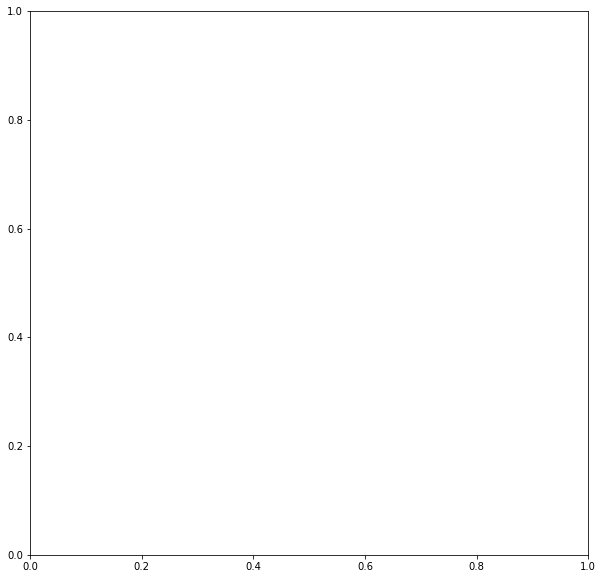

In [21]:
AnimalProfile={'Type':'Good',
     'rewardType':'Progressive',
     #'initialSpeed':['10'],
     #'Speed':['10'],
     'Tag':'Early-Lesion_DLS-Early-var'
              }
animalList=batch_get_animal_list(root,AnimalProfile)
#animalList=['Rat145']
SESSION_LIMIT=-5
plt.figure(figsize=(10,10))

TreadmillSpd,ForwardSpd=plot_speed_correlation(root,animalList,SESSION_LIMIT);

In [35]:
session='Rat147_2017_11_06_11_08'
data=Data(root,session[:6],session,redoPreprocess=False)
# treadmillSpeed =read_in_file(data,' ',extension=".variablespeed",exclude=None,valueType=float)
# treadmillSpeed

4.368


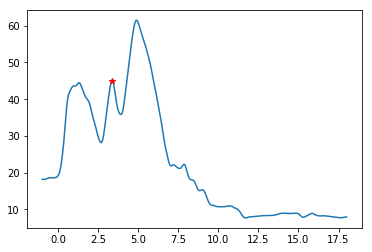

In [51]:
i=80

plt.plot(data.timeTreadmill[i],data.position[i])
plt.plot(data.entranceTime[i]-1,data.position[i][int(data.entranceTime[i]*25)],'r*')
print(data.entranceTime[i])